<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

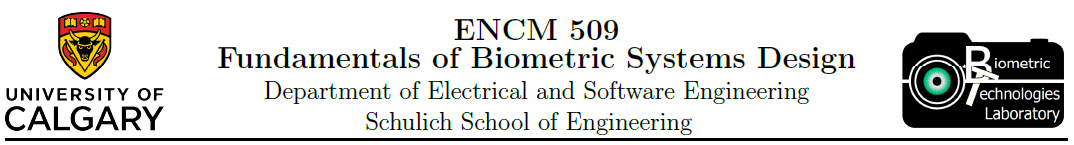

<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
    <h3>Talha Khalil, 30037871</h3>
</center>

# Introduction
The purpose of this lab is to understand how to process fingerprints and get them ready for matching. As well as to get an understanding of the affects of de-noising, applying a histogram as well as changing the block size, and threshold values.

In [1]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# Function Definitions

In [2]:
# Function for processing fingerprints
# Returns a dictionary of images.
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    output['input_img'] = img
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    orientation_img = visualize_angles(segmented_img, mask, angles, W=block_size)
    output['orientation_img'] = orientation_img
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_img'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [3]:
# Displays the output of fingerprint processing, where img is an aggregation of the output images.
def display_fingerprint_processing_output(img):
    plt.figure(figsize=(14,8))
    plt.subplot(2,4,1); plt.imshow(img['input_img'], cmap='gray'); plt.title('Input Image')
    plt.subplot(2,4,2); plt.imshow(img['normalized_img'], cmap='gray'); plt.title('Normalized')
    plt.subplot(2,4,3); plt.imshow(img['segmented_img'], cmap='gray'); plt.title('Segmentation')
    plt.subplot(2,4,4); plt.imshow(img['orientation_img']); plt.title('Ridges Orientation')
    plt.subplot(2,4,5); plt.imshow(img['gabor_img'], cmap='gray'); plt.title('Gabor Filter')
    plt.subplot(2,4,6); plt.imshow(img['thin_img'], cmap='gray'); plt.title('Fingerprint Skeleton')
    plt.subplot(2,4,7); plt.imshow(img['minutiae_img']); plt.title('Minutiae')
    plt.subplot(2,4,8); plt.imshow(img['singularities_img']); plt.title('Singularities')

In [4]:
# Given an original input image, processes and calculates regular and adaptive equalization
# Outputs a dictionary of input img, and regular and adaptive equalization
def histogram_equalization(img):
    output = {}
    output['input'] = img
    output['regular'] = img_as_ubyte(equalize_hist(img))
    output['adaptive'] = img_as_ubyte(equalize_adapthist(img))
    return output

In [5]:
# Displays the output of histogram equalization
# Given the output of the histogram_equalization function
def display_histogram_equalization(img):
    plt.figure(figsize=(14,6))
    plt.subplot(2,3,1)
    plt.imshow(img['input']); plt.title('Original image')
    plt.subplot(2,3,2)
    plt.imshow(img['regular']); plt.title('Regular equalization')
    plt.subplot(2,3,3)
    plt.imshow(img['adaptive']); plt.title('Adaptive Equalization');
    plt.subplot(2,3,4)
    plt.hist(img['input'].ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')
    plt.subplot(2,3,5)
    plt.hist(img['regular'].ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')
    plt.subplot(2,3,6)
    plt.hist(img['adaptive'].ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity');

In [6]:
def show_difference_in_equalizing(img, title, ifDisplay ,block_size=16, threshold=0.4):
    print('Comparing Regular vs Equalization' + title)
    print('Orginal: ')
    fingerprint_processing_output = fingerprint_processing(img, block_size, threshold)
    histogram_equalization_output = histogram_equalization(img)
    print('Regular Equalization: ')
    regular_equalization = fingerprint_processing(histogram_equalization_output['regular'],block_size, threshold)
    print('Adaptive Equalization: ')
    adaptive_equalization = fingerprint_processing(histogram_equalization_output['adaptive'], block_size, threshold)
    if(ifDisplay):
        print('Displaying Original Fingerprint Processing')
        display_fingerprint_processing_output(fingerprint_processing_output)
        display_histogram_equalization(histogram_equalization_output)

In [7]:
# De-noise an image using  median
# Requires an image and returns a dictionary of de-noised images.
def de_noise_image(img):
    output = {}
    output['input'] = img

    # with the Median filter is not necessary to convert back to uint8 
    img_median = median(img)
    output['median'] = img_median
    return output

In [8]:
# Given the output of de_noise_image plots the graphs
def display_de_noise_difference(img, title):
    print('Median De-noise difference: ' + title)
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.imshow(img['input']); plt.title('Original image')
    plt.subplot(1,2,2)
    plt.imshow(img['median']); plt.title('Median filter');

In [9]:
def show_difference_in_de_noising(img, title):
    de_noise_output = de_noise_image(img)
    display_de_noise_difference(de_noise_output, title)
    print('Orginal: ')
    fingerprint_processing_output = fingerprint_processing(img)
    print('Denoised: ')
    de_noise_fingerprint = fingerprint_processing(de_noise_output['median'])

In [10]:
# Loading Fingerprint Data
talha_good = img_as_ubyte(imread('Fingerprints/Talha_Right_Thumb/2.bmp', as_gray=True))
talha_bad = img_as_ubyte(imread('Fingerprints/Talha_Right_Thumb/8.bmp', as_gray=True))
shelby_good = img_as_ubyte(imread('Fingerprints/Shelby_Right_Thumb/3.bmp', as_gray=True))
shelby_bad = img_as_ubyte(imread('Fingerprints/Shelby_Right_Thumb/7.bmp', as_gray=True))

# Exercise 1

- **Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

Comparing Regular vs Equalization for Talha Good
Orginal: 
Total of minutiae detected: 76
Total of singularities detected: 4
Regular Equalization: 
Total of minutiae detected: 42
Total of singularities detected: 4
Adaptive Equalization: 
Total of minutiae detected: 72
Total of singularities detected: 4
Displaying Original Fingerprint Processing


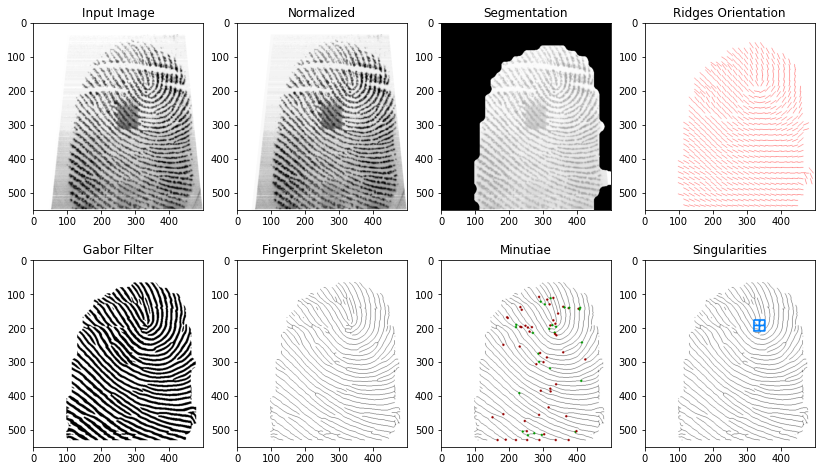

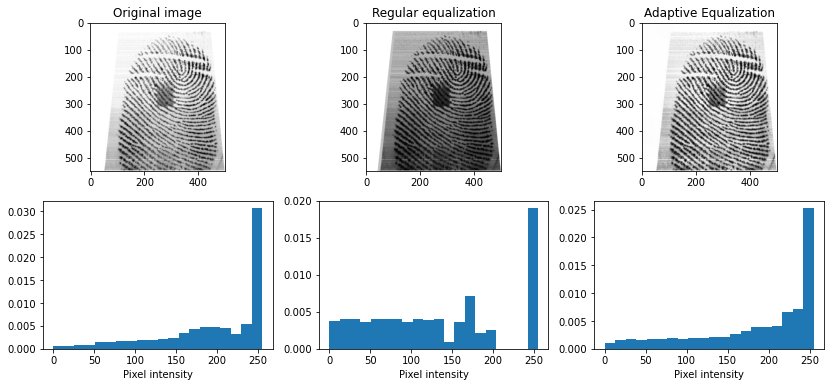

In [11]:
show_difference_in_equalizing(talha_good, " for Talha Good", True)

Comparing Regular vs Equalization for Talha Bad
Orginal: 
Total of minutiae detected: 51
Total of singularities detected: 0
Regular Equalization: 
Total of minutiae detected: 33
Total of singularities detected: 0
Adaptive Equalization: 
Total of minutiae detected: 54
Total of singularities detected: 0
Displaying Original Fingerprint Processing


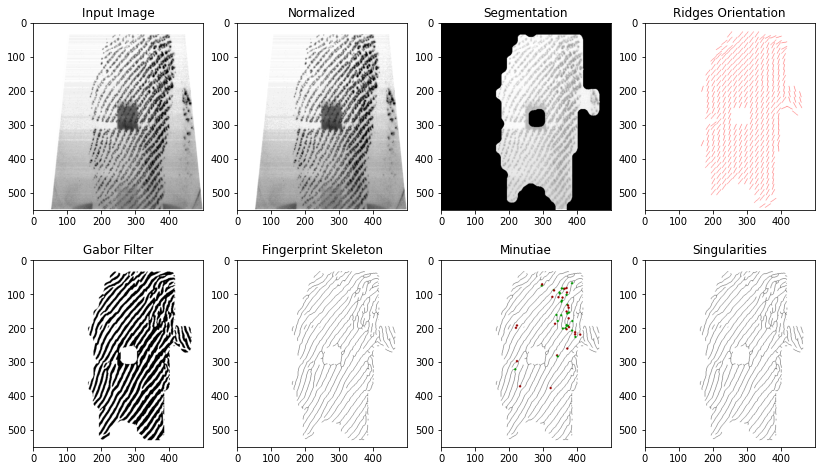

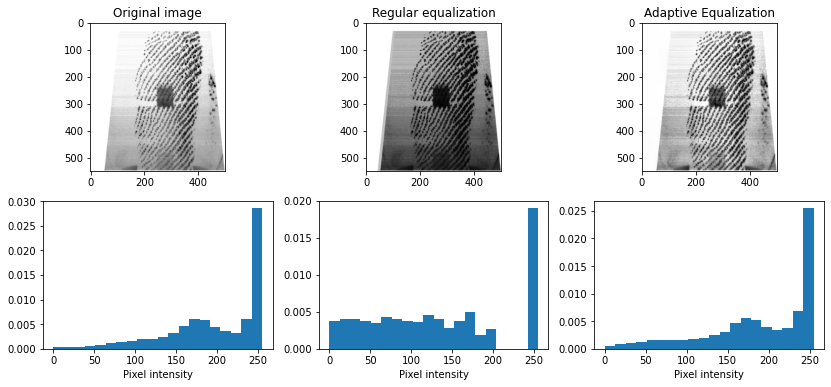

In [12]:
show_difference_in_equalizing(talha_bad, " for Talha Bad", True)

Comparing Regular vs Equalization for Shelby Good
Orginal: 
Total of minutiae detected: 269
Total of singularities detected: 2
Regular Equalization: 
Total of minutiae detected: 195
Total of singularities detected: 4
Adaptive Equalization: 
Total of minutiae detected: 434
Total of singularities detected: 10
Displaying Original Fingerprint Processing


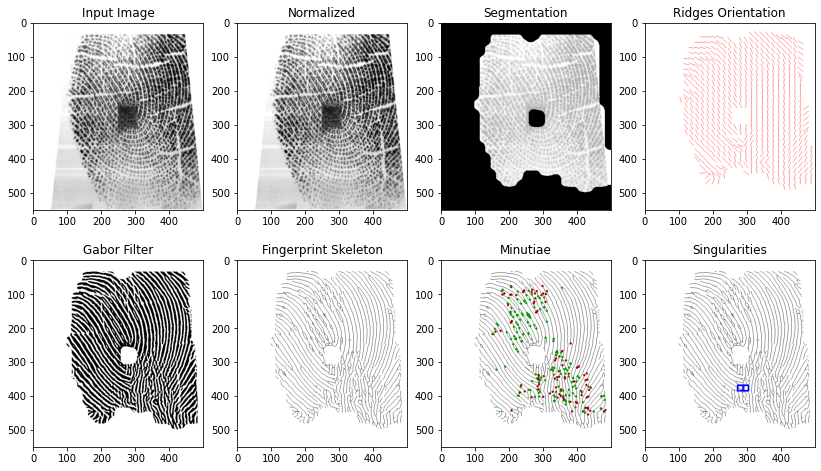

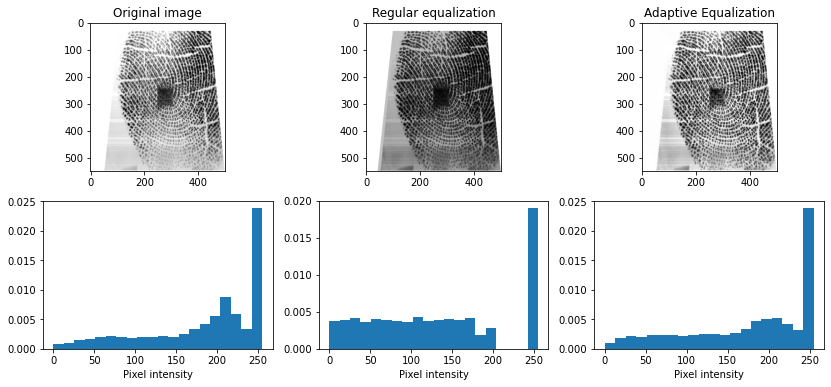

In [13]:
show_difference_in_equalizing(shelby_good, " for Shelby Good", True)

Comparing Regular vs Equalization for Shelby Bad
Orginal: 
Total of minutiae detected: 60
Total of singularities detected: 0
Regular Equalization: 
Total of minutiae detected: 45
Total of singularities detected: 1
Adaptive Equalization: 
Total of minutiae detected: 150
Total of singularities detected: 4
Displaying Original Fingerprint Processing


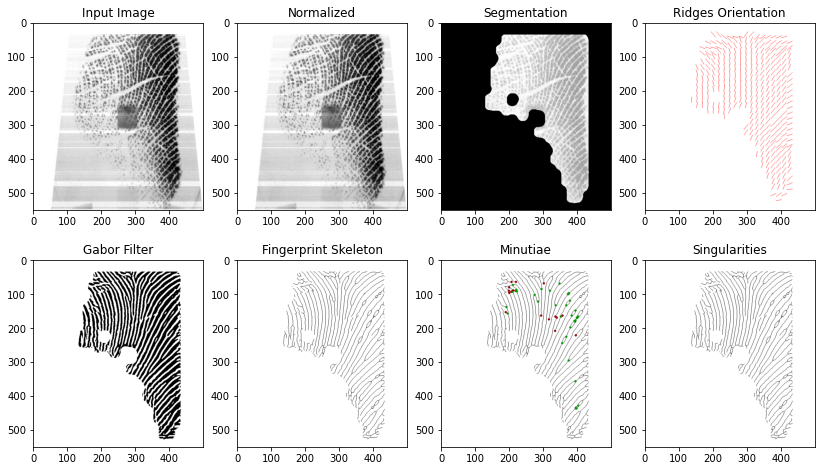

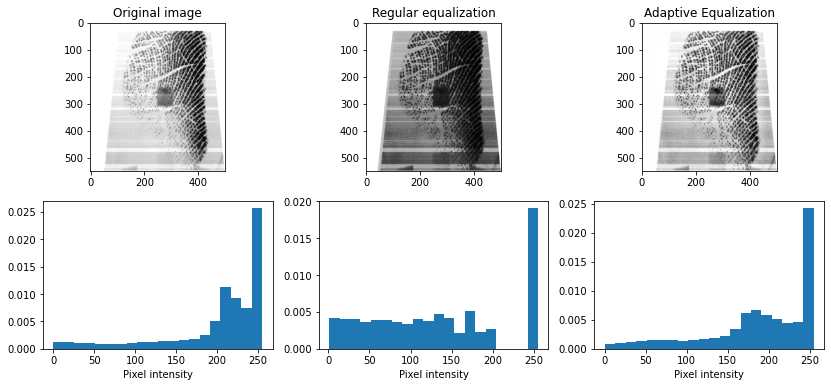

In [14]:
show_difference_in_equalizing(shelby_bad, " for Shelby Bad", True)

### Analysis
When comparing the four cases with and without histogram equalization we can observe that when regular equalization is added there are less minutiae that are detected, and with the Shelby data set specifically we can see that the amount of singularities that are detected increased. When adaptive equalization is used instead we can observe that in all cases more singularities are detected, and in most cases the amount of detected minutiae also increased. The only point where the minutiae did not increases was for the 'Talha Good' set which could be attributed to the fact that it was already a really clean signal so equalizing it in this case made it lose some detail. Whereas in most cases adaptive equalization increased the quality. For regular equalization it make sense that less minutiae were detected as the image seems to be of poorer quality when compared to the original where as the general increase when using adaptive also makes sense when the original image has more of a drastic brightness difference between the lightest and darkest part of the image. This is supported by the increase in the minutiae detected in the Shelby set, and barely a differencein the Talha set.

# Excercise 2

- **Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

Median De-noise difference: for Talha Good
Orginal: 
Total of minutiae detected: 76
Total of singularities detected: 4
Denoised: 
Total of minutiae detected: 72
Total of singularities detected: 4


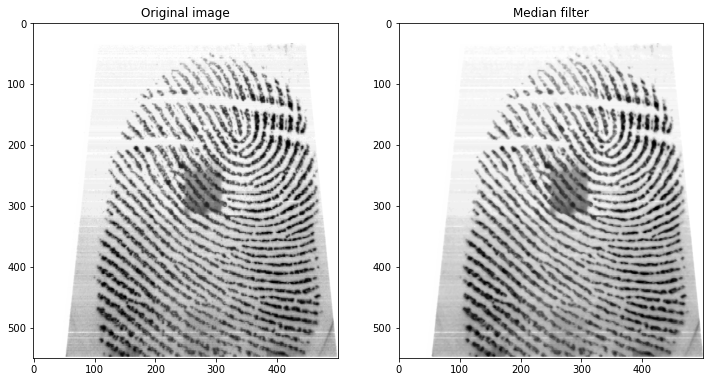

In [15]:
show_difference_in_de_noising(talha_good, 'for Talha Good')

Median De-noise difference: for Talha Bad
Orginal: 
Total of minutiae detected: 51
Total of singularities detected: 0
Denoised: 
Total of minutiae detected: 30
Total of singularities detected: 0


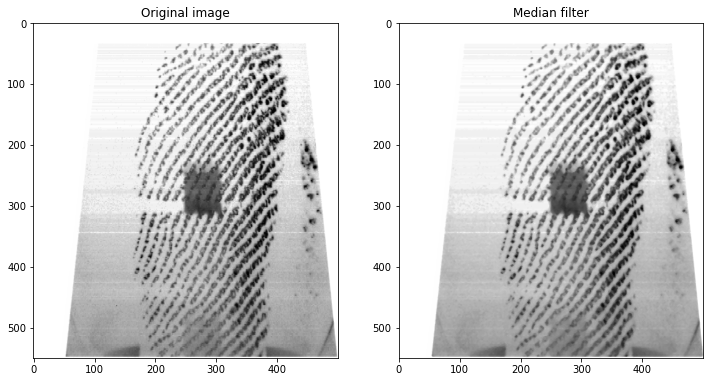

In [16]:
show_difference_in_de_noising(talha_bad, 'for Talha Bad')

Median De-noise difference: for Shelby Good
Orginal: 
Total of minutiae detected: 269
Total of singularities detected: 2
Denoised: 
Total of minutiae detected: 152
Total of singularities detected: 0


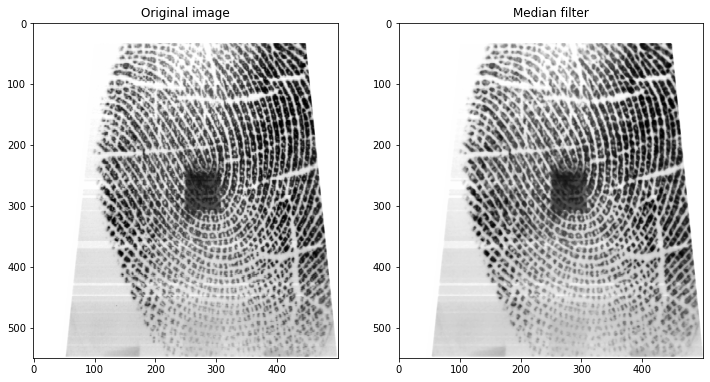

In [17]:
show_difference_in_de_noising(shelby_good, 'for Shelby Good')

Median De-noise difference: for Shelby Bad
Orginal: 
Total of minutiae detected: 60
Total of singularities detected: 0
Denoised: 
Total of minutiae detected: 72
Total of singularities detected: 0


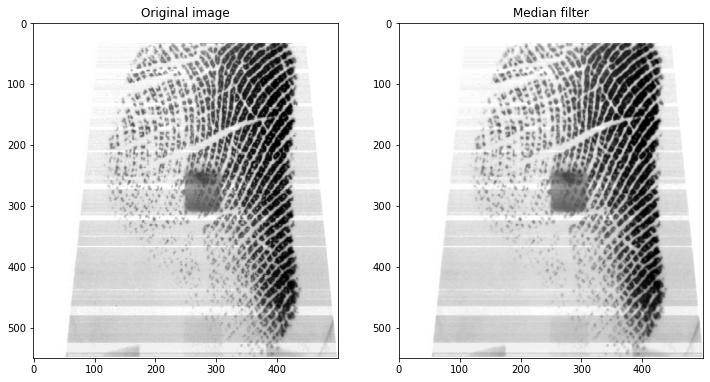

In [18]:
show_difference_in_de_noising(shelby_bad, 'for Shelby Bad')

### Analysis
When comparing the data with a median de-noising stage it is clear that the number of detected minutiae and singularities in most cases is lower than when there is no de-noising stage added. The only exception here being the 'Shelby Bad' case where the detected minutiae increased. It should also be noted that to the human eye the median filter does not seem to be making no discernable difference.

# Excerise 3

- **Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

In [19]:
show_difference_in_equalizing(talha_good, " for Talha Good, Block Size 16, threshold 0.4", False)
show_difference_in_equalizing(talha_good, " for Talha Good, Block Size 10, threshold 0.4", False, 10, 0.4)
show_difference_in_equalizing(talha_good, " for Talha Good, Block Size 16, threshold 0.5", False, 16, 0.5)

Comparing Regular vs Equalization for Talha Good, Block Size 16, threshold 0.4
Orginal: 
Total of minutiae detected: 76
Total of singularities detected: 4
Regular Equalization: 
Total of minutiae detected: 42
Total of singularities detected: 4
Adaptive Equalization: 
Total of minutiae detected: 72
Total of singularities detected: 4
Comparing Regular vs Equalization for Talha Good, Block Size 10, threshold 0.4
Orginal: 
Total of minutiae detected: 458
Total of singularities detected: 4
Regular Equalization: 
Total of minutiae detected: 218
Total of singularities detected: 4
Adaptive Equalization: 
Total of minutiae detected: 745
Total of singularities detected: 4
Comparing Regular vs Equalization for Talha Good, Block Size 16, threshold 0.5
Orginal: 
Total of minutiae detected: 65
Total of singularities detected: 4
Regular Equalization: 
Total of minutiae detected: 31
Total of singularities detected: 2
Adaptive Equalization: 
Total of minutiae detected: 72
Total of singularities detecte

In [20]:
show_difference_in_equalizing(talha_bad, " for Talha Bad, Block Size 16, threshold 0.4", False)
show_difference_in_equalizing(talha_bad, " for Talha Bad, Block Size 10, threshold 0.4", False, 10, 0.4)
show_difference_in_equalizing(talha_bad, " for Talha Bad, Block Size 16, threshold 0.5", False, 16, 0.5)

Comparing Regular vs Equalization for Talha Bad, Block Size 16, threshold 0.4
Orginal: 
Total of minutiae detected: 51
Total of singularities detected: 0
Regular Equalization: 
Total of minutiae detected: 33
Total of singularities detected: 0
Adaptive Equalization: 
Total of minutiae detected: 54
Total of singularities detected: 0
Comparing Regular vs Equalization for Talha Bad, Block Size 10, threshold 0.4
Orginal: 
Total of minutiae detected: 454
Total of singularities detected: 0
Regular Equalization: 
Total of minutiae detected: 156
Total of singularities detected: 0
Adaptive Equalization: 
Total of minutiae detected: 561
Total of singularities detected: 0
Comparing Regular vs Equalization for Talha Bad, Block Size 16, threshold 0.5
Orginal: 
Total of minutiae detected: 46
Total of singularities detected: 0
Regular Equalization: 
Total of minutiae detected: 18
Total of singularities detected: 0
Adaptive Equalization: 
Total of minutiae detected: 38
Total of singularities detected: 

In [21]:
show_difference_in_equalizing(shelby_good, " for Shelby Good, Block Size 16, threshold 0.4", False)
show_difference_in_equalizing(shelby_good, " for Shelby Good, Block Size 10, threshold 0.4", False, 10, 0.4)
show_difference_in_equalizing(shelby_good, " for Shelby Good, Block Size 16, threshold 0.5", False, 16, 0.5)

Comparing Regular vs Equalization for Shelby Good, Block Size 16, threshold 0.4
Orginal: 
Total of minutiae detected: 269
Total of singularities detected: 2
Regular Equalization: 
Total of minutiae detected: 195
Total of singularities detected: 4
Adaptive Equalization: 
Total of minutiae detected: 434
Total of singularities detected: 10
Comparing Regular vs Equalization for Shelby Good, Block Size 10, threshold 0.4
Orginal: 
Total of minutiae detected: 803
Total of singularities detected: 5
Regular Equalization: 
Total of minutiae detected: 329
Total of singularities detected: 2
Adaptive Equalization: 
Total of minutiae detected: 1007
Total of singularities detected: 30
Comparing Regular vs Equalization for Shelby Good, Block Size 16, threshold 0.5
Orginal: 
Total of minutiae detected: 221
Total of singularities detected: 0
Regular Equalization: 
Total of minutiae detected: 78
Total of singularities detected: 0
Adaptive Equalization: 
Total of minutiae detected: 321
Total of singularit

In [22]:
show_difference_in_equalizing(shelby_bad, " for Shelby Bad, Block Size 16, threshold 0.4", False)
show_difference_in_equalizing(shelby_bad, " for Shelby Bad, Block Size 10, threshold 0.4", False, 10, 0.4)
show_difference_in_equalizing(shelby_bad, " for Shelby Bad, Block Size 16, threshold 0.5", False, 16, 0.5)

Comparing Regular vs Equalization for Shelby Bad, Block Size 16, threshold 0.4
Orginal: 
Total of minutiae detected: 60
Total of singularities detected: 0
Regular Equalization: 
Total of minutiae detected: 45
Total of singularities detected: 1
Adaptive Equalization: 
Total of minutiae detected: 150
Total of singularities detected: 4
Comparing Regular vs Equalization for Shelby Bad, Block Size 10, threshold 0.4
Orginal: 
Total of minutiae detected: 364
Total of singularities detected: 3
Regular Equalization: 
Total of minutiae detected: 69
Total of singularities detected: 5
Adaptive Equalization: 
Total of minutiae detected: 564
Total of singularities detected: 21
Comparing Regular vs Equalization for Shelby Bad, Block Size 16, threshold 0.5
Orginal: 
Total of minutiae detected: 48
Total of singularities detected: 0
Regular Equalization: 
Total of minutiae detected: 11
Total of singularities detected: 0
Adaptive Equalization: 
Total of minutiae detected: 100
Total of singularities detec

### Analysis
In all cases reducing the block size resulted in an increase in detected minutiae, where as the singularities were seen to increase in most cases and decrease in others. Where no affect on singularities was seen in the Talha data sets, whereas in the 'Shelby Good' there was an increase in singularities detected for all cases but for regular equalization. In 'Shelby Bad' it was also observed to have an increase in singularities detected. In all cases, increasing the threshold led to less minutiae  and less singularities being detected.

# Conclusion

This lab has provided a clearer understanding of how fingerprint data is collected and processed. From the  exercises in the lab the following cna be concluded. Adding adaptive histogram equalization will increase the number of minutiae detected and in cases where the fingerprint has a large range in brightness values the singularities as well. Adding a median de-noising method will cause a decrease in detected minutiae and singularities. Lastly, increasing the block size will increase the number of minutiae detected and in most cases incease the amount of singularities detected as well. Increasing the threshold  will decrease the number of minutiae and singularities detected in the fingerprint samples. 